In [64]:
import os
from sys import stdout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

In [92]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [93]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [100]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [83]:
x_df = pd.read_csv('avg_norm.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(24, 1446)
(1446,)
24


252.071400  252.201700  252.331900  252.462200  252.592400  252.722600  \
0     0.021587    0.021441    0.021291    0.021880    0.021664    0.021075   
1     0.026370    0.026642    0.026547    0.026462    0.026634    0.026581   
2     0.022681    0.022737    0.022276    0.022898    0.022830    0.022728   
3     0.024106    0.024033    0.023864    0.024128    0.024015    0.024126   
4     0.022621    0.022661    0.022401    0.022621    0.022714    0.022769   
5     0.022423    0.021908    0.021901    0.022549    0.022164    0.022158   
6     0.027824    0.027949    0.027859    0.027894    0.027960    0.027953   
7     0.022082    0.021763    0.021886    0.022141    0.022122    0.021941   
8     0.019303    0.019211    0.019010    0.019402    0.019290    0.019481   
9     0.020854    0.020552    0.020294    0.020688    0.020814    0.020779   
10    0.019886    0.019788    0.019543    0.020004    0.019950    0.019723   
11    0.021513    0.021545    0.021343    0.021837    0.021576    0.021531   
12    0.023659    0.023392    0.023287    0.023560    0.023513    0.023679   
13    0.020027    0.019873    0.019719    0.020479    0.019981    0.020064   
14    0.024311    0.024410    0.024374    0.024699    0.024438    0.024400   
15    0.023875    0.023713    0.023830    0.024001    0.024066    0.023788   
16    0.022471    0.022601    0.022454    0.022575    0.022550    0.022527   
17    0.023049    0.022902    0.022640    0.023418    0.023049    0.023358   
18    0.023053    0.022621    0.022689    0.023382    0.022944    0.023006   
19    0.019450    0.018897    0.018758    0.019389    0.019110    0.019139   
20    0.024461    0.024464    0.024419    0.024554    0.024585    0.024576   
21    0.021752    0.021391    0.021326    0.021942    0.021553    0.021814   
22    0.020721    0.020634    0.020767    0.020886    0.020771    0.020959   
23    0.018950    0.018762    0.018700    0.019208    0.019001    0.019090   

    252.852900  252.983100  253.113300  253.243600  ...  428.718100  \
0     0.021748    0.021961    0.021617    0.021503  ...    0.019178   
1     0.026635    0.026474    0.026619    0.026699  ...    0.019997   
2     0.022736    0.022983    0.022890    0.022400  ...    0.020306   
3     0.024204    0.024213    0.024186    0.024204  ...    0.020380   
4     0.023096    0.023208    0.022707    0.022377  ...    0.019011   
5     0.022697    0.022626    0.022245    0.021787  ...    0.019999   
6     0.028103    0.028150    0.028023    0.027968  ...    0.020215   
7     0.021898    0.022389    0.021996    0.021901  ...    0.021156   
8     0.019634    0.019589    0.019538    0.019061  ...    0.017575   
9     0.021291    0.021121    0.020670    0.020460  ...    0.019804   
10    0.019881    0.020004    0.019762    0.019677  ...    0.017211   
11    0.021861    0.021635    0.021736    0.021381  ...    0.019915   
12    0.023919    0.023999    0.023503    0.023448  ...    0.020126   
13    0.020301    0.020575    0.020031    0.020006  ...    0.019528   
14    0.024680    0.024785    0.024728    0.024649  ...    0.019438   
15    0.023742    0.024059    0.024063    0.023768  ...    0.020084   
16    0.022673    0.022848    0.022669    0.022632  ...    0.018941   
17    0.023611    0.023401    0.022892    0.022986  ...    0.020522   
18    0.022994    0.023289    0.023109    0.022838  ...    0.020316   
19    0.019712    0.020052    0.019163    0.018696  ...    0.017959   
20    0.024419    0.024860    0.024585    0.024642  ...    0.020286   
21    0.022037    0.021963    0.021477    0.021438  ...    0.019511   
22    0.021152    0.020964    0.020877    0.020295  ...    0.019456   
23    0.019631    0.019534    0.019112    0.018964  ...    0.017992   

    428.828600  428.939000  429.049500  429.159900  429.270300  429.380600  \
0     0.019368    0.020147    0.020016    0.019211    0.019072    0.018749   
1     0.019729    0.019555    0.019649    0.019676    0.019714    0.019417   
2     0.020312    0.019751    0.020045    0

[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]


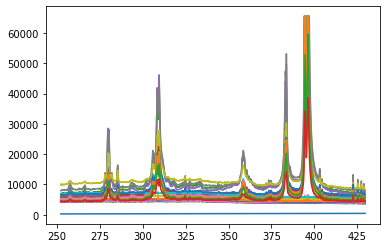

In [75]:
#This is just for visualizing the various plots of the samples

df = pd.read_csv('./ref_new/1.csv')
data=df.values
wl= data[0]
print(wl)

for i in range(len(values)):
    plt.plot(wl, data[i,:])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""



In [67]:
df_y = pd.read_csv('concentration_1.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)
values=df_y.values
y_all=pd.DataFrame(values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(24, 9)


Reference Number      Si     Fe     Mg     Cu       Zn     Mn       Al  \
0                  1   0.185  0.228  2.940  0.0304  0.0620  0.280  96.0000   
1                  2   0.360  0.600  1.100  0.0700  0.2000  0.830  96.5787   
2                  3   9.140  1.010  0.200  0.4200  3.6000  0.410  84.7770   
3                  4   8.565  0.000  0.293  0.8870  2.6360  0.330  86.5650   
4                  5   9.500  0.000  0.391  0.0000  0.0580  0.016  90.0210   
5                  6   7.220  0.140  0.360  0.0840  0.1200  0.053  91.8090   
6                  7   7.460  0.530  0.036  0.1400  0.1500  0.100  91.4140   
7                  8  12.900  0.120  0.520  0.1550  0.5200  0.286  84.7905   
8                  9   8.750  0.460  1.710  0.0290  2.0000  0.056  85.3100   
9                 10   0.260  0.420  1.260  0.0200  0.0040  1.160  96.8346   
10                11   0.070  0.100  0.410  0.1800  0.0600  1.450  97.6000   
11                12   0.160  0.310  0.880  0.1000  0.1100  1.140  97.1500   
12                13   6.120  0.000  0.320  0.0000  0.0054  0.016  93.5352   
13                14  12.530  0.310  0.025  0.0500  0.0560  0.033  86.8180   
14                15   0.530  0.230  0.770  0.0310  0.0060  0.024  98.3881   
15                16   0.160  0.200  4.540  0.0520  0.0500  0.380  94.5340   
16                17   3.000  0.795  0.570  0.1540  4.2900  0.037  90.4640   
17                18   9.460  1.190  0.390  0.1600  3.1000  0.260  84.8070   
18                19   0.530  0.180  3.570  5.0600  1.9000  0.130  88.2100   
19                24   9.190  0.000  0.339  0.0000  0.0057  0.008  90.4538   
20                25   6.160  0.000  0.363  0.0000  0.0060  0.206  93.2574   
21                26   0.180  0.205  2.480  5.4400  1.6000  0.079  89.8430   
22                28   0.180  0.500  1.110  0.0520  0.1500  1.260  96.7210   
23                29   0.180  0.350  2.030  6.0800  1.3500  0.450  89.3900   

      Total  
0   99.7254  
1   99.7387  
2   99.5570  
3   99.2760  
4   99.9860  
5   99.7860  
6   99.8300  
7   99.2915  
8   98.3150  
9   99.9586  
10  99.8700  
11  99.8500  
12  99.9966  
13  99.8220  
14  99.9791  
15  99.9160  
16  99.3100  
17  99.3670  
18  99.5800  
19  99.9965  
20  99.9924  
21  99.8270  
22  99.9730  
23  99.8300

In [69]:
y_cu = concentration[:,1]
print(y_cu)
print(y_cu.shape)

[ 0.185  0.36   9.14   8.565  9.5    7.22   7.46  12.9    8.75   0.26
  0.07   0.16   6.12  12.53   0.53   0.16   3.     9.46   0.53   9.19
  6.16   0.18   0.18   0.18 ]
(24,)


In [70]:
y_df= pd.DataFrame(y_cu)
#df_y_si

In [71]:
target = [251.59, 288.12, 390.60]
target

[251.59, 288.12, 390.6]

In [101]:
a = []
b = []
for t in target:
    for i in range(len(wl)):
        if abs(wl[i]-t) < 1.5:
            a.append(wl[i])
            b.append(i)
            
print("number of selected wavelengths: ",len(a), "\n")
print(a, "\n")
print(b)

number of selected wavelengths:  56 

[252.0714, 252.2017, 252.3319, 252.4622, 252.5924, 252.7226, 252.8529, 252.9831, 286.6869, 286.8158, 286.9447, 287.0735, 287.2024, 287.3313, 287.4601, 287.5889, 287.7178, 287.8466, 287.9754, 288.1042, 288.233, 288.3618, 288.4906, 288.6194, 288.7482, 288.8769, 289.0057, 289.1345, 289.2632, 289.3919, 289.5207, 389.203, 389.3212, 389.4394, 389.5576, 389.6757, 389.7939, 389.912, 390.0301, 390.1481, 390.2662, 390.3842, 390.5023, 390.6203, 390.7382, 390.8562, 390.9741, 391.0921, 391.21, 391.3278, 391.4457, 391.5635, 391.6814, 391.7992, 391.917, 392.0347] 

[0, 1, 2, 3, 4, 5, 6, 7, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115]


In [102]:
print(values.shape)
values[:, b].shape
x_selecta = pd.DataFrame(values[:, b])
x_selecta

(24, 1446)


0         1         2         3         4         5         6   \
0   0.021587  0.021441  0.021291  0.021880  0.021664  0.021075  0.021748   
1   0.026370  0.026642  0.026547  0.026462  0.026634  0.026581  0.026635   
2   0.022681  0.022737  0.022276  0.022898  0.022830  0.022728  0.022736   
3   0.024106  0.024033  0.023864  0.024128  0.024015  0.024126  0.024204   
4   0.022621  0.022661  0.022401  0.022621  0.022714  0.022769  0.023096   
5   0.022423  0.021908  0.021901  0.022549  0.022164  0.022158  0.022697   
6   0.027824  0.027949  0.027859  0.027894  0.027960  0.027953  0.028103   
7   0.022082  0.021763  0.021886  0.022141  0.022122  0.021941  0.021898   
8   0.019303  0.019211  0.019010  0.019402  0.019290  0.019481  0.019634   
9   0.020854  0.020552  0.020294  0.020688  0.020814  0.020779  0.021291   
10  0.019886  0.019788  0.019543  0.020004  0.019950  0.019723  0.019881   
11  0.021513  0.021545  0.021343  0.021837  0.021576  0.021531  0.021861   
12  0.023659  0.023392  0.023287  0.023560  0.023513  0.023679  0.023919   
13  0.020027  0.019873  0.019719  0.020479  0.019981  0.020064  0.020301   
14  0.024311  0.024410  0.024374  0.024699  0.024438  0.024400  0.024680   
15  0.023875  0.023713  0.023830  0.024001  0.024066  0.023788  0.023742   
16  0.022471  0.022601  0.022454  0.022575  0.022550  0.022527  0.022673   
17  0.023049  0.022902  0.022640  0.023418  0.023049  0.023358  0.023611   
18  0.023053  0.022621  0.022689  0.023382  0.022944  0.023006  0.022994   
19  0.019450  0.018897  0.018758  0.019389  0.019110  0.019139  0.019712   
20  0.024461  0.024464  0.024419  0.024554  0.024585  0.024576  0.024419   
21  0.021752  0.021391  0.021326  0.021942  0.021553  0.021814  0.022037   
22  0.020721  0.020634  0.020767  0.020886  0.020771  0.020959  0.021152   
23  0.018950  0.018762  0.018700  0.019208  0.019001  0.019090  0.019631   

          7         8         9   ...        46        47        48        49  \
0   0.021961  0.022990  0.022693  ...  0.022719  0.022876  0.022737  0.022829   
1   0.026474  0.027759  0.027944  ...  0.023118  0.023038  0.022868  0.023068   
2   0.022983  0.023545  0.023554  ...  0.024481  0.024593  0.024555  0.024579   
3   0.024213  0.025491  0.025482  ...  0.023947  0.023718  0.023638  0.024089   
4   0.023208  0.023409  0.023375  ...  0.023662  0.023400  0.023131  0.023120   
5   0.022626  0.022265  0.022695  ...  0.023820  0.023548  0.023556  0.023742   
6   0.028150  0.029477  0.029188  ...  0.023702  0.023569  0.023377  0.023492   
7   0.022389  0.023673  0.023569  ...  0.023728  0.023606  0.023553  0.023920   
8   0.019589  0.019968  0.019917  ...  0.022795  0.022600  0.022418  0.022689   
9   0.021121  0.021576  0.021409  ...  0.025529  0.025423  0.025483  0.025406   
10  0.020004  0.021684  0.021720  ...  0.022760  0.022538  0.022707  0.022774   
11  0.021635  0.022376  0.022574  ...  0.023457  0.023380  0.023202  0.023784   
12  0.023999  0.024505  0.024411  ...  0.024252  0.024155  0.024215  0.024155   
13  0.020575  0.020969  0.021215  ...  0.024554  0.024820  0.024246  0.024570   
14  0.024785  0.026051  0.025920  ...  0.023127  0.023167  0.022945  0.022885   
15  0.024059  0.024755  0.024778  ...  0.023078  0.023027  0.023182  0.023331   
16  0.022848  0.024141  0.024202  ...  0.023012  0.022998  0.022802  0.023028   
17  0.023401  0.024166  0.023990  ...  0.024212  0.024212  0.023930  0.024138   
18  0.023289  0.023988  0.023829  ...  0.023621  0.023717  0.023621  0.023894   
19  0.020052  0.019602  0.019766  ...  0.022754  0.022769  0.022374  0.022335   
20  0.024860  0.025527  0.025592  ...  0.024252  0.024265  0.024203  0.024258   
21  0.021963  0.021970  0.022014  ...  0.023681  0.023261  0.023753  0.023407   
22  0.020964  0.021310  0.021365  ...  0.024346  0.024130  0.024062  0.024032   
23  0.019534  0.020046  0.020086  ...  0.023926  0.023881  0.023720  0.023803   

          50        51        52        53        54        55  
0   0.023037  0.02

In [139]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#print(X_test)

(19, 56) (19, 1)
(5, 56) (5, 1)


In [140]:
n_components= 20

# PCA

X_std = StandardScaler().fit_transform(x_selecta.values)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 20)
[51.74 87.81 95.23 98.42 98.69 98.89 99.07 99.23 99.35 99.45 99.55 99.63
 99.7  99.76 99.81 99.85 99.89 99.92 99.94 99.96]


In [141]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.953627331660495 -3659.191864572407
0.9354341915702457 73833.76330129079


In [142]:
n_components=18

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 56)
(56,)
19
(19, 18)
[ 51.5   87.83  94.97  98.21  98.55  98.81  99.03  99.24  99.39  99.52
  99.63  99.72  99.79  99.84  99.89  99.94  99.98 100.  ]


In [143]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_c = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -1.288226611115678
MSE:  32.725576288725314


In [144]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_df, 20)

100% completed
Optimised number of PLS components:  10
Wavelengths to be discarded  37
Optimised MSEP  8.595735112200257



(19, 19) (19, 1)
(5, 19) (5, 1)
50% completed
Suggested number of components:  11



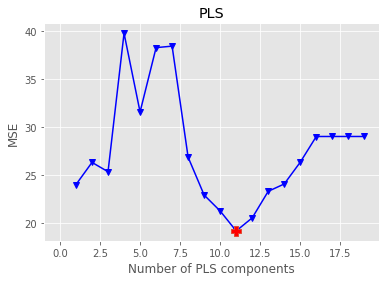

R2 calib: 0.986
R2 CV: 0.039
MSE calib: 0.283
MSE CV: 19.218


In [145]:
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

optimise_pls_cv(X_train,y_train, 20, plot_components=True)

R2_pred: 0.46480809333258766
R2_cv: -0.06445424845194236 

[real, predictions]
[[ 0.53       -0.25032003]
 [ 0.07       -3.8209037 ]
 [ 8.565      11.76968294]
 [ 0.18       -0.93238306]
 [ 0.26       -1.26885094]]


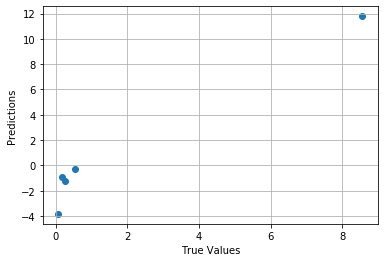

In [153]:
# Define PLS object
pls = PLSRegression(n_components=10)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred:", score_pred)
print("R2_cv:",score_cv, "\n")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [38]:
Xmsc = msc(x_df.values)
Xmsc[0]

array([[-0.00432779, -0.00445947, -0.00459477, ..., -0.0070824 ,
        -0.00697957, -0.00694981],
       [-0.00300622, -0.00289671, -0.00330585, ..., -0.01077987,
        -0.01069323, -0.01084606],
       [-0.00490734, -0.00516648, -0.00522813, ..., -0.00778191,
        -0.00777324, -0.00787054],
       ...,
       [-0.00333413, -0.00366814, -0.00372828, ..., -0.0062468 ,
        -0.00596367, -0.0061552 ],
       [-0.00552155, -0.00564901, -0.00586207, ..., -0.00698353,
        -0.0073193 , -0.00732596],
       [-0.00662448, -0.00681398, -0.00687648, ..., -0.00805989,
        -0.00812742, -0.00792078]])

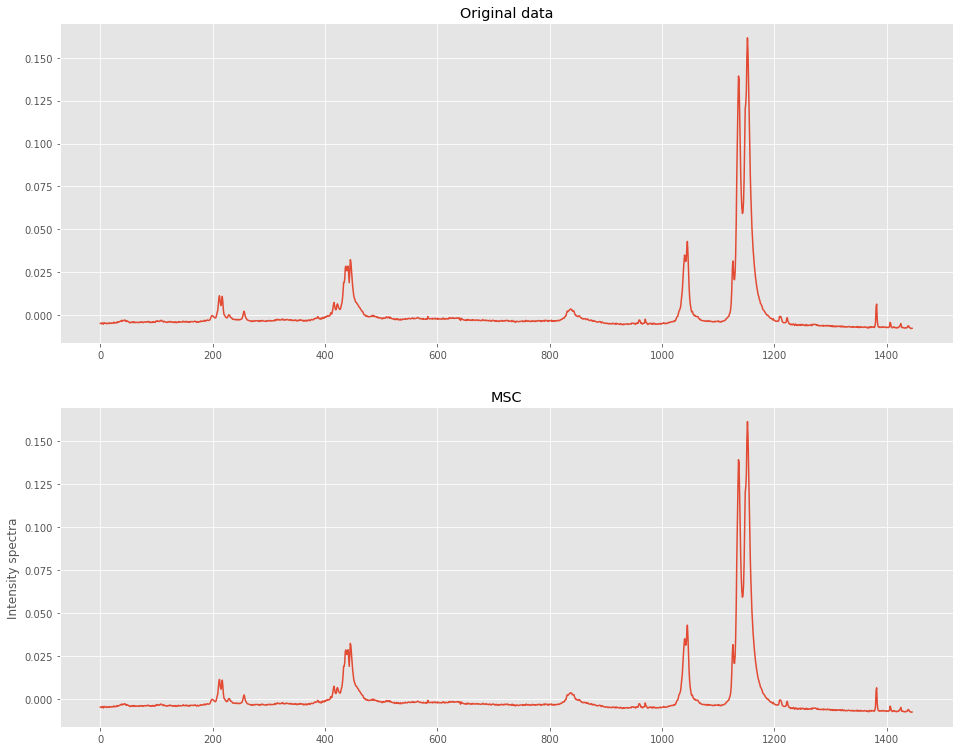

In [136]:
X = x_df.values[0,:].reshape(1,-1)
#wl
Xmsc = msc(X)[0] # Take the first element of the output tuple

%matplotlib inline
## Plot spectra
plt.figure(figsize=(16,20))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(311)
    plt.plot(X.T)
    #plt.plot(wl.T, X.T)
    plt.title('Original data')
    ax2 = plt.subplot(312)
    plt.plot(Xmsc.T)
    #plt.plot(wl.T, Xmsc.T)
    plt.ylabel('Intensity spectra')
    plt.title('MSC')
    plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)
        0
6   0.530
0   0.228
7   0.120
10  0.100
17  1.190


# Principal Components Analysis

In [57]:
n_components=20

x_df = pd.read_csv('avg_base_norm.csv', sep = ',')
x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 1446)
(1446,)
24
(24, 20)
[51.76 73.33 83.06 88.24 91.3  93.83 95.26 96.51 97.32 97.86 98.27 98.64
 98.92 99.14 99.31 99.45 99.57 99.68 99.76 99.84]


In [58]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

In [43]:
print(score_c, score_cv)
print(mse_c, mse_cv)

0.8356021451900544 -585.2005450442468
0.016023177342218996 57.13453683570308


In [44]:
n_components=15

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 1446)
(1446,)
19
(19, 15)
[58.75 76.53 87.   91.07 92.86 94.57 95.95 97.06 97.78 98.34 98.75 99.03
 99.25 99.45 99.63]


In [45]:
x_test1

array([[-3.24574886e+01, -9.41637595e+00, -9.93741303e+00,
         9.74181581e+00,  1.32616555e+00,  3.99905766e-01,
        -1.25226783e+00,  1.45574313e+00,  9.95867265e-01,
         2.73742983e+00, -3.39051534e-01, -3.26699845e-01,
         1.21739838e+00, -1.09771613e+00, -7.52143000e-01],
       [ 1.84161235e+01, -4.92165333e-01,  2.10138366e+01,
         1.15387371e+00, -3.05017342e+00,  5.82548481e+00,
         7.85393498e+00, -2.65988596e+00,  2.95306263e-01,
        -1.92387296e+00, -6.54316276e-01,  5.61489972e+00,
        -3.76805081e-01,  2.00651126e+00, -2.03461115e+00],
       [ 7.70064672e-01, -4.29935059e+00,  8.41795415e+00,
        -3.47916389e+00,  1.94998523e+01,  5.57734880e+00,
        -8.58052689e+00,  6.70339408e+00, -8.15365917e-01,
        -2.47952163e+00,  1.05709930e+00,  3.28304546e+00,
        -5.19023371e-02, -1.25051791e+00, -9.51345974e-01],
       [ 1.39610856e+01,  2.57653465e+01, -3.23730369e+00,
        -2.13471244e+01, -8.43794732e-01,  4.31605470

In [46]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_c = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2: ", score_c)
print("MSE: ", mse_c)

R2:  -1.0310418664760772
MSE:  0.33850936083513616


37% completed
Suggested number of components:  9



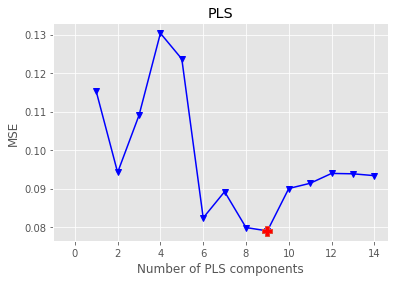

R2 calib: 0.956
R2 CV: 0.190
MSE calib: 0.004
MSE CV: 0.079


In [59]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [63]:
pls = PLSRegression(n_components=2)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2: ", score_c)
print("MSE: ", mse_c)

R2:  -1.0310418664760812
MSE:  0.33850936083513683


#### This is the *mathematical* way to do it

(1508.8695652173917+0j)
[47.43 65.94 74.18 81.21 85.42 88.88 91.66 93.52 94.9  95.92 96.71 97.28
 97.78 98.2  98.59 98.86 99.09 99.3  99.46 99.62]


"# Make a list of (eigenvalue, eigenvector) tuples\neig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]\n\n# Sort the (eigenvalue, eigenvector) tuples from high to low\neig_pairs.sort(key=lambda x: x[0], reverse=True)\n\n# Visually confirm that the list is correctly sorted by decreasing eigenvalues\nprint('Eigenvalues in descending order:')\nfor i in eig_pairs[:20]: #only first 20 eigenvalues\n    print(i[0])\n"

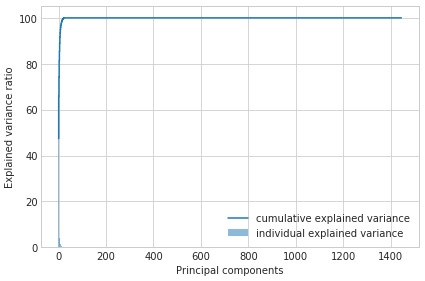

In [24]:
cov_mat = np.cov(X_std.T) #covariance matrix
#print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#print('Eigenvectors \n%s' %eig_vecs)
#print('\nEigenvalues \n%s' %eig_vals)

tot = sum(eig_vals)
print(tot)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
#print(cum_var_exp.real)
print(np.round(cum_var_exp[:20].real, decimals=2)) # same as above but only first 10 elements

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    
'''# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs[:20]: #only first 20 eigenvalues
    print(i[0])
'''

# Linear Regression
this is ordinary least square regression

In [21]:


# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [22]:
b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[0.031      2.68721343]
 [5.06       1.607639  ]
 [0.16       2.5961751 ]
 [0.1        2.56690439]
 [0.052      2.07902308]]


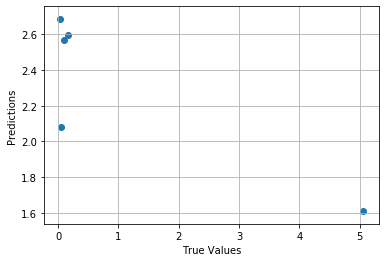

In [23]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [24]:
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2)

RMSE:  2.6496662152506527
R^2:  -0.7725194926143217


# Partial Least Square Regression

In [17]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

## No preprocessing

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=4)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)
y_test

(19, 1446) (19, 1)
(5, 1446) (5, 1)


0
22  1.260
21  0.079
0   0.280
3   0.330
12  0.016

100% completed
Suggested number of components:  3



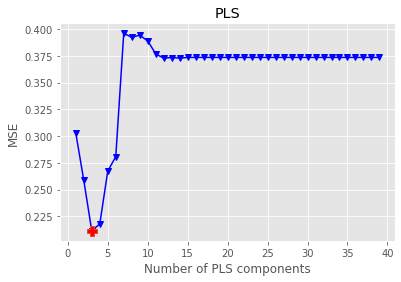

R2 calib: 0.524
R2 CV: -0.105
MSE calib: 0.091
MSE CV: 0.211


In [73]:
optimise_pls_cv(x_df, y_df, 40, plot_components=True)
#optimise_pls_cv(x_df, y_all, 40, plot_components=True)

In [74]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_df, y_df)
# Cross-validation
y_cv = cross_val_predict(pls, x_df, y_df, cv=10)
# Calculate scores
score = r2_score(y_df, y_cv)
mse = mean_squared_error(y_df, y_cv)

print("R^2_cv", score)
print("MSE: ", mse)

R^2_cv -0.10453192234784381
MSE:  0.21126596081807159


100% completed
Suggested number of components:  10



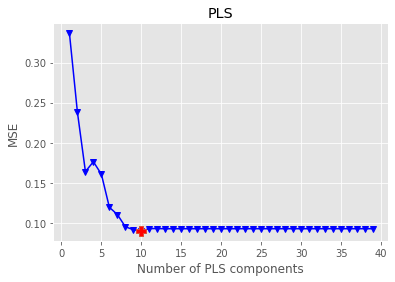

R2 calib: 0.999
R2 CV: 0.523
MSE calib: 0.000
MSE CV: 0.090


In [75]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

In [76]:
# Define PLS object
pls = PLSRegression(n_components=20)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.5084917693555373
MSE:  0.09259163843885171


In [77]:
y_cv = cross_val_predict(pls, X_test, y_test, cv=5)
# Calculate scores
score = r2_score(y_test, y_cv)
print("R2_cv_test: ", score)

R2_cv_test:  -4.217422818297326


R2_pred:  -1.1784393998401468
R2_cv:  0.5084917693555373

TEST
 [real, predictions]
[[ 1.26000000e+00  1.15724521e-04]
 [ 7.90000000e-02 -1.17881677e-01]
 [ 2.80000000e-01 -2.86885696e-01]
 [ 3.30000000e-01  8.29855935e-01]
 [ 1.60000000e-02 -1.70203957e-02]]

TRAIN
 [real, predictions]
[[1.45  1.45 ]
 [0.1   0.1  ]
 [1.14  1.14 ]
 [0.41  0.41 ]
 [0.016 0.016]
 [0.008 0.008]
 [0.26  0.26 ]
 [0.38  0.38 ]
 [0.037 0.037]
 [0.45  0.45 ]
 [0.033 0.033]
 [0.286 0.286]
 [1.16  1.16 ]
 [0.13  0.13 ]
 [0.206 0.206]
 [0.056 0.056]
 [0.83  0.83 ]
 [0.053 0.053]
 [0.024 0.024]]


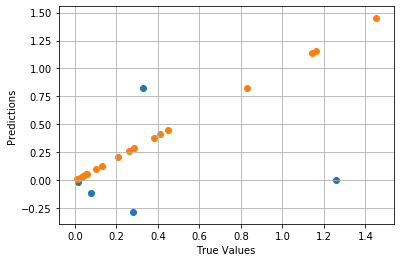

In [78]:
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

print("TRAIN\n [real, predictions]")
print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [33]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [34]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, df_y, 15)

KeyboardInterrupt: 

In [ ]:
opt_Xc.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state=4)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

In [ ]:
# Define PLS object
pls = PLSRegression(n_components=13)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

In [ ]:
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

print("TRAIN\n [real, predictions]")
print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [79]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=4)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


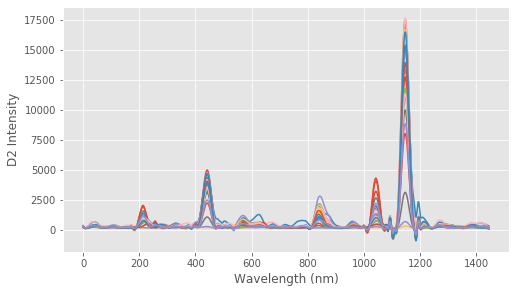

100% completed
Suggested number of components:  1



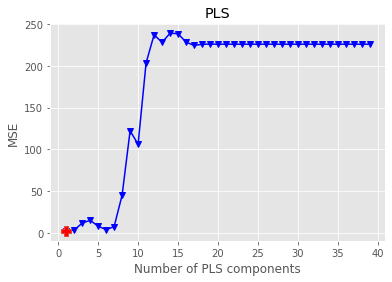

R2 calib: 0.030
R2 CV: -0.577
MSE calib: 1.324
MSE CV: 2.154


In [80]:
# Calculate second derivative
X2 = savgol_filter(x_df, 101, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2_1, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  6



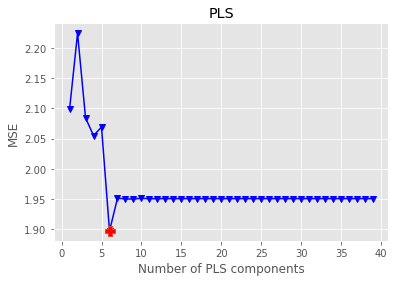

R2 calib: 0.995
R2 CV: -0.380
MSE calib: 0.007
MSE CV: 1.897


In [65]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=2) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=2) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

In [54]:
# Define PLS object
pls = PLSRegression(n_components=19)
# Fit
pls.fit(X2_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R2_cv: ", score)
print("MSE: ", mse)




R2_cv:  -0.4132153315854279
MSE:  1.9423276614929568


R2_pred:  0.24340944615397486
R2_cv:  -0.4132153315854279

[real, predictions]
[[ 1.11        1.6149564 ]
 [ 2.48        1.65092226]
 [ 2.94        1.64802885]
 [ 0.293       1.59828036]
 [ 0.32       -0.16135806]]


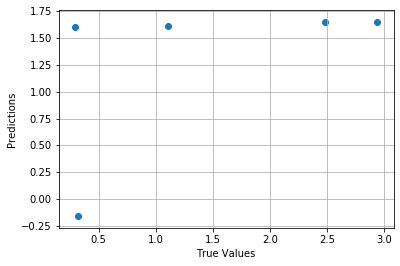

In [55]:
y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [43]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)

In [44]:




y_df= pd.DataFrame(y_cu)


100% completed
Suggested number of components:  2



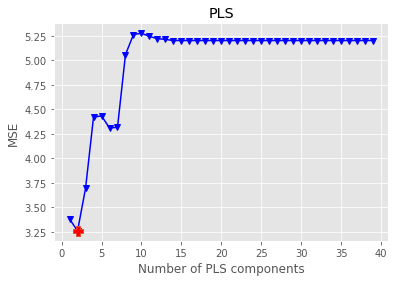

R2 calib: 0.302
R2 CV: -0.141
MSE calib: 1.993
MSE CV: 3.260


In [45]:
optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)

In [46]:
# Define PLS object
pls = PLSRegression(n_components=2)
# Fit
pls.fit(Xn_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, Xn_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  -0.1406614981571661
MSE:  3.2597790548449623


R2_pred:  -1.0379453710255424
R2_cv:  -0.1406614981571661

[real, predictions]
[[ 0.052       1.49182935]
 [ 5.44       -0.79888926]
 [ 0.0304     -1.306341  ]
 [ 0.887      -0.42762889]
 [ 0.         -0.81549208]]


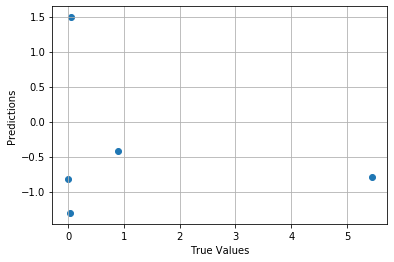

In [47]:
y_pred = pls.predict(Xn_test)

# Cross-validation
y_cv = cross_val_predict(pls, Xn_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [79]:
from sklearn.linear_model import ElasticNet,ElasticNetCV

In [80]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [81]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.76, MSE:0.26, RMSE:0.51
Alpha:0.0010, R2:0.27, MSE:0.23, RMSE:0.48
Alpha:0.0100, R2:0.00, MSE:0.20, RMSE:0.45
Alpha:0.1000, R2:0.00, MSE:0.20, RMSE:0.45
Alpha:0.3000, R2:0.00, MSE:0.20, RMSE:0.45
Alpha:0.5000, R2:0.00, MSE:0.20, RMSE:0.45
Alpha:0.7000, R2:0.00, MSE:0.20, RMSE:0.45
Alpha:1.0000, R2:0.00, MSE:0.20, RMSE:0.45


In [82]:
model = ElasticNet(alpha=0.01).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.0
RMSE:  0.4498464447149879
R^2:  -0.0026330216989842725


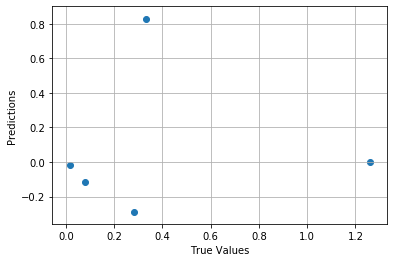

In [83]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [84]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(20, 1446) (20, 1)
(4, 1446) (4, 1)


In [85]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(4,)
(20,)


In [86]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2500, max_depth=30, random_state = 42)
# Train the model on training data
#rf.fit(X_train, y_train);

rf.fit(X_train, y_train);

In [87]:
# Use the forest's predict method on the test data

#predictions = rf.predict(X_test)
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.27


In [88]:
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2)

RMSE:  0.313128813780083
R^2:  -2.111582323558003


In [89]:
y_test= y_test.reshape((len(y_test), 1))
print(y_test.shape)
print(type(y_test))
predictions=predictions.reshape((len(y_test), 1))
print(predictions.shape)
print(type(y_test))
#print((y_test, predictions))

(4, 1)
<class 'numpy.ndarray'>
(4, 1)
<class 'numpy.ndarray'>


In [90]:
b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[0.016     0.1086304]
 [0.053     0.2018772]
 [0.45      0.9706772]
 [0.056     0.3565812]]


Text(0, 0.5, 'Predictions')

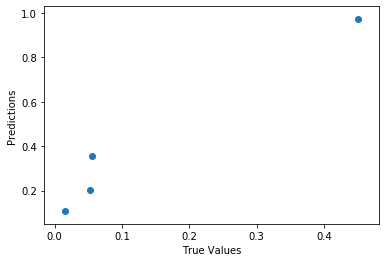

In [91]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [55]:
#I don't remember what's this

#X_train = normalize(X_train, axis=1)
#X_test = normalize(X_test, axis=1)

In [41]:
c

NameError: name 'c' is not defined

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

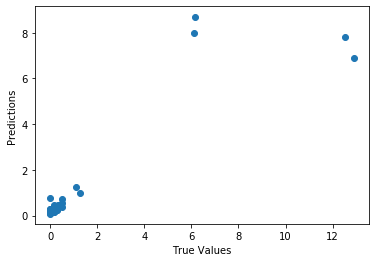

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



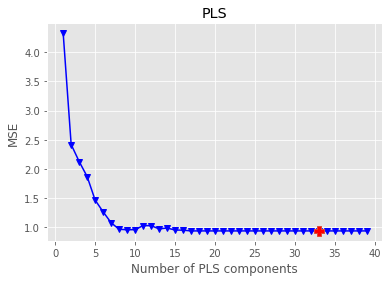

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

0     1     2     3     4     5
0   7.84  0.22  0.54  0.19  0.57  0.27
1   8.62  0.12  0.35  0.06 -0.12 -0.06
2  10.50  0.13 -0.61  0.45  0.15 -0.03
3  -0.28  0.42  1.56 -0.11 -0.34  0.95
4   9.93  0.09  0.29 -0.26  0.65  0.14

In [152]:
np.round(y_test, decimals=2)

0     1     2     3     4     5
20   6.16  0.00  0.36  0.00  0.01  0.21
12   6.12  0.00  0.32  0.00  0.01  0.02
13  12.53  0.31  0.02  0.05  0.06  0.03
22   0.18  0.50  1.11  0.05  0.15  1.26
7   12.90  0.12  0.52  0.16  0.52  0.29